# Dashboard UDLA (60/40)

Esta hoja combina:
- **60% superior**: 6 gráficos comparativos de `UDLA` vs otros sectores (formato desglose).
- **40% inferior**: gráfico no comparativo del sector `UDLA` por años (formato edades).


In [12]:
import re
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from routes.main import cargar_parroquias, clasificar_sectorial, normalizar_nombre

def normalizar_texto(texto):
    if pd.isna(texto):
        return ""
    texto = str(texto).strip().lower()
    texto = "".join(
        c for c in unicodedata.normalize("NFD", texto)
        if unicodedata.category(c) != "Mn"
    )
    texto = re.sub(r"\\s+", " ", texto)
    return texto

gdf = clasificar_sectorial(cargar_parroquias(scope="todas"))
lookup_codigo = {
    str(row.get("codigo", "")).strip(): row.get("sector")
    for _, row in gdf.iterrows()
    if str(row.get("codigo", "")).strip()
}
lookup_nombre = {
    normalizar_nombre(row.get("nombre", "")): row.get("sector")
    for _, row in gdf.iterrows()
}

# ===== Datos comparativos (desglose) =====
df_desglose = pd.read_excel("data/parroquiasDesglose.xlsx")
df_desglose.columns = df_desglose.columns.str.strip()

categorias_edad = [
    "De 0 a 4 años", "De 5 a 9 años", "De 10 a 14 años", "De 15 a 19 años",
    "De 20 a 24 años", "De 25 a 29 años", "De 30 a 34 años", "De 35 a 39 años",
    "De 40 a 44 años", "De 45 a 49 años", "De 50 a 54 años", "De 55 a 59 años",
    "De 60 a 64 años", "De 65 a 69 años", "De 70 a 74 años", "De 75 a 79 años",
    "De 80 a 84 años", "De 85 o mas"
]

mapa_cols = {normalizar_texto(c): c for c in df_desglose.columns}
col_parroquia = mapa_cols.get("parroquia")
col_codigo = next((c for c in df_desglose.columns if "codigo" in normalizar_texto(c)), None)
if col_parroquia is None or col_codigo is None:
    raise ValueError("No se encontraron columnas parroquia/codigo en parroquiasDesglose.xlsx")

mapa_edades = {normalizar_texto(c): c for c in df_desglose.columns}
columnas_edad = []
for c in categorias_edad:
    clave = normalizar_texto(c)
    if clave not in mapa_edades:
        raise ValueError(f"Falta columna de edad: {c}")
    columnas_edad.append(mapa_edades[clave])

df_desglose[columnas_edad] = df_desglose[columnas_edad].apply(pd.to_numeric, errors="coerce").fillna(0)

def normalizar_codigo(valor):
    if pd.isna(valor):
        return ""
    s = str(valor).strip()
    if s.endswith(".0"):
        s = s[:-2]
    return s

df_desglose["codigo_norm"] = df_desglose[col_codigo].apply(normalizar_codigo)
df_desglose["parroquia_norm"] = df_desglose[col_parroquia].apply(lambda x: normalizar_nombre(str(x)))
df_desglose["SECTOR_MAPA"] = df_desglose["codigo_norm"].map(lookup_codigo)
sin_sector = df_desglose["SECTOR_MAPA"].isna()
df_desglose.loc[sin_sector, "SECTOR_MAPA"] = df_desglose.loc[sin_sector, "parroquia_norm"].map(lookup_nombre)
df_desglose = df_desglose[df_desglose["SECTOR_MAPA"].notna()].copy()

sector_edad = df_desglose.groupby("SECTOR_MAPA")[columnas_edad].sum()
sector_edad_pct = sector_edad.div(sector_edad.sum(axis=1), axis=0)

# ===== Datos sector UDLA no comparativo (edades por años) =====
df_raw = pd.read_excel("data/parroquiasEdades.xlsx", header=None)
def encontrar_header(df):
    for i in range(min(20, len(df))):
        fila = [str(x).strip() for x in df.iloc[i].tolist()]
        if "SECTOR" in fila and "Grupo Edad" in fila:
            return i
    return None

header_idx = encontrar_header(df_raw)
if header_idx is None:
    raise ValueError("No se encontro header en parroquiasEdades.xlsx")

df_edades = pd.read_excel("data/parroquiasEdades.xlsx", header=header_idx)
df_edades.columns = df_edades.columns.astype(str).str.strip()

orden_grupos = df_edades["Grupo Edad"].dropna().drop_duplicates().tolist()
orden_grupos = list(reversed(orden_grupos))
df_edades["Grupo Edad"] = pd.Categorical(df_edades["Grupo Edad"], categories=orden_grupos, ordered=True)

year_candidates = []
for c in df_edades.columns:
    texto = str(c).strip()
    if texto.isdigit() and len(texto) == 4:
        year_candidates.append(c)

sector_grupo = df_edades.groupby(["Parroquia", "Grupo Edad"], as_index=False)[year_candidates].sum()
sector_grupo = sector_grupo.rename(columns={c: str(c).strip() for c in year_candidates})
anios = [c for c in ["2001", "2010", "2022"] if c in sector_grupo.columns]

alias_sector = {"GUAYABAMBA": "NORORIENTE", "QUITO": "CENTRO"}
sector_grupo["parroquia_norm"] = sector_grupo["Parroquia"].apply(lambda x: normalizar_nombre(str(x)))
sector_grupo["SECTOR_MAPA"] = sector_grupo["parroquia_norm"].map(lookup_nombre)
sin_sector_ed = sector_grupo["SECTOR_MAPA"].isna()
sector_grupo.loc[sin_sector_ed, "SECTOR_MAPA"] = sector_grupo.loc[sin_sector_ed, "parroquia_norm"].map(alias_sector)
sector_grupo = sector_grupo[sector_grupo["SECTOR_MAPA"].notna()].copy()
sector_grupo = sector_grupo.groupby(["SECTOR_MAPA", "Grupo Edad"], as_index=False)[anios].sum()
sector_grupo = sector_grupo.rename(columns={"SECTOR_MAPA": "SECTOR"})

if "UDLA" not in sector_edad_pct.index or "UDLA" not in sector_grupo["SECTOR"].unique():
    raise ValueError("No hay datos suficientes de UDLA en alguna de las fuentes.")


C:\Users\andreidavid.flores\AppData\Local\Temp\ipykernel_14772\2130549722.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_grupo = df_edades.groupby(["Parroquia", "Grupo Edad"], as_index=False)[year_candidates].sum()
C:\Users\andreidavid.flores\AppData\Local\Temp\ipykernel_14772\2130549722.py:113: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sector_grupo = sector_grupo.groupby(["SECTOR_MAPA", "Grupo Edad"], as_index=False)[anios].sum()


C:\Users\andreidavid.flores\AppData\Local\Temp\ipykernel_14772\3824500085.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.985])


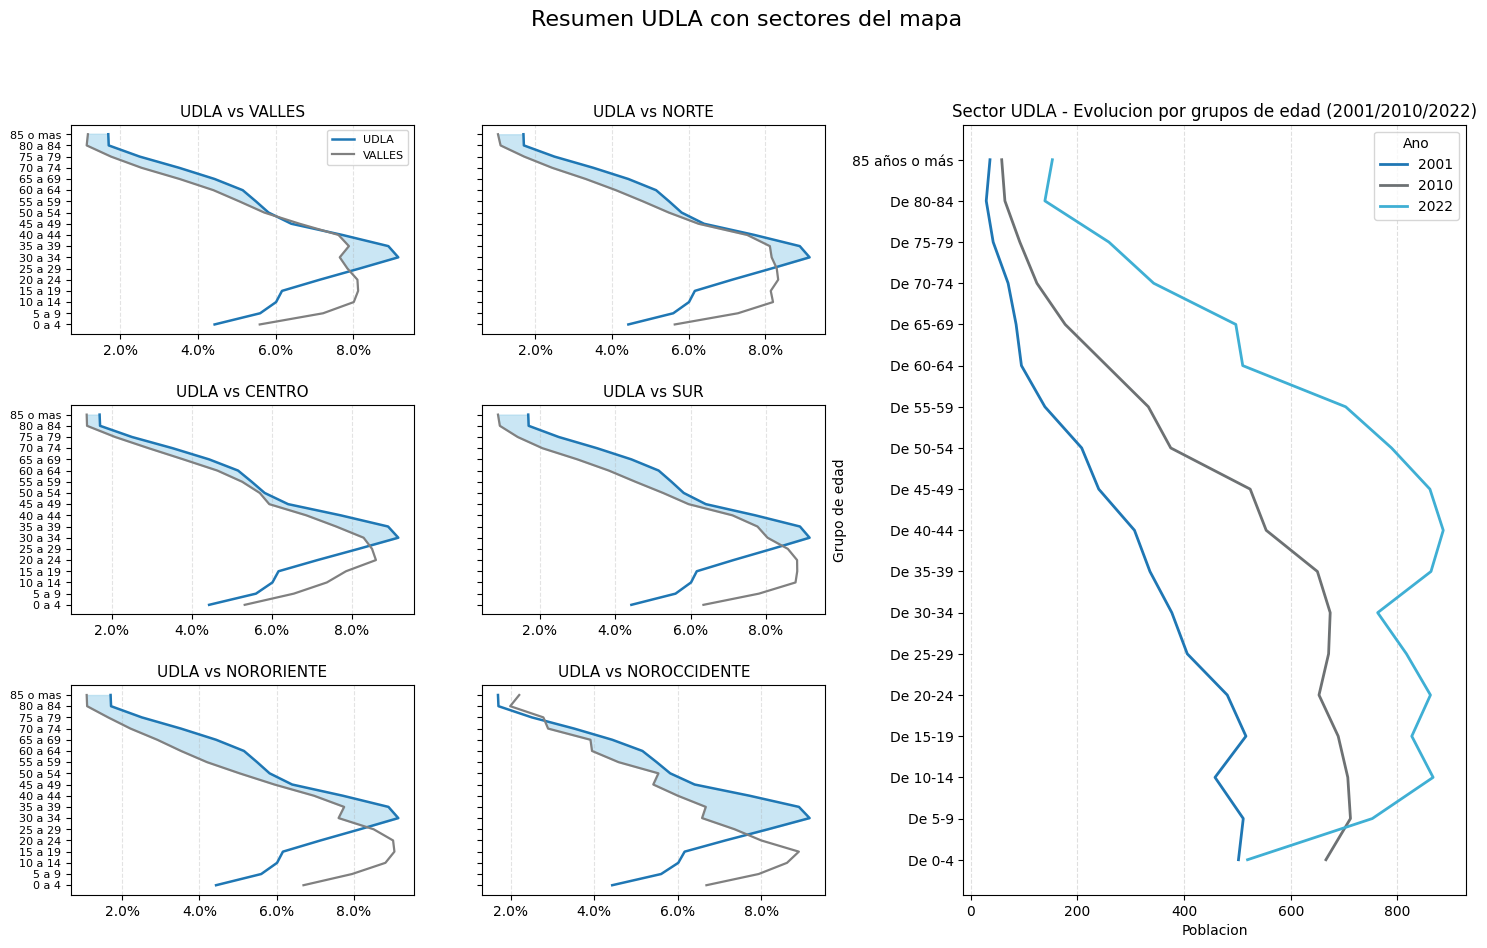

In [14]:
# ===== Figura 60/40 vertical (izquierda/derecha) =====
fig = plt.figure(figsize=(18, 10))
layout = fig.add_gridspec(1, 2, width_ratios=[60, 40], wspace=0.22)

# 60% izquierdo: 6 comparativos UDLA vs otros (3x2)
top_grid = layout[0].subgridspec(3, 2, hspace=0.34, wspace=0.2)
posiciones = list(range(len(categorias_edad)))
def limpiar_etiqueta_edad(etiqueta):
    txt = etiqueta.replace("De ", "").strip()
    txt = re.sub(r"\s+a(?:\u00f1|n|\?)?(?:o|os)\b", "", txt, flags=re.IGNORECASE)
    txt = re.sub(r"\s+a(?:\u00f1|\?)\b", "", txt, flags=re.IGNORECASE)
    return txt.strip()

etiquetas_edad_cortas = [limpiar_etiqueta_edad(e) for e in categorias_edad]
sectores_orden = ["VALLES", "NORTE", "CENTRO", "SUR", "NORORIENTE", "NOROCCIDENTE"]
otros_udla = [s for s in sectores_orden if s in sector_edad_pct.index]
if len(otros_udla) != 6:
    raise ValueError(f"Se esperaban 6 sectores para comparar con UDLA y hay {len(otros_udla)}: {otros_udla}")

for idx, sector in enumerate(otros_udla):
    ax = fig.add_subplot(top_grid[idx // 2, idx % 2])
    udla_vals = sector_edad_pct.loc["UDLA", columnas_edad].values
    other_vals = sector_edad_pct.loc[sector, columnas_edad].values

    ax.plot(udla_vals, posiciones, label="UDLA", linewidth=1.8)
    ax.plot(other_vals, posiciones, label=sector, color="#808080", linewidth=1.6)
    ax.fill_betweenx(
        posiciones,
        udla_vals,
        other_vals,
        where=(udla_vals > other_vals),
        interpolate=True,
        color="#9fd3eb",
        alpha=0.55,
    )

    ax.set_title(f"UDLA vs {sector}", fontsize=11)
    ax.set_yticks(posiciones)
    if idx % 2 == 0:
        ax.set_yticklabels(etiquetas_edad_cortas, fontsize=8)
    else:
        ax.set_yticklabels([])
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.grid(axis="x", linestyle="--", alpha=0.35)
    if idx == 0:
        ax.legend(loc="best", fontsize=8)

# 40% derecho: grafico no comparativo sector UDLA (lineas por ano)
ax_bottom = fig.add_subplot(layout[1])
serie_udla = sector_grupo[sector_grupo["SECTOR"] == "UDLA"].set_index("Grupo Edad")[anios]
colores_anio = {
    "2001": "#1f77b4",
    "2010": "#6d7173",
    "2022": "#3fafd4",
}
for anio in anios:
    ax_bottom.plot(
        serie_udla[anio].values,
        serie_udla.index,
        label=anio,
        linewidth=2,
        color=colores_anio.get(anio, "#333333"),
    )

ax_bottom.set_title("Sector UDLA - Evolucion por grupos de edad (2001/2010/2022)")
ax_bottom.set_xlabel("Poblacion")
ax_bottom.set_ylabel("Grupo de edad")
ax_bottom.grid(axis="x", linestyle="--", alpha=0.4)
ax_bottom.legend(title="Ano")

fig.suptitle("Resumen UDLA con sectores del mapa", fontsize=16, y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.985])
plt.show()